In [ ]:
# Get open ai key
from google.colab import userdata
key_opi = userdata.get('openai_key')
rapid_key = userdata.get('rapid_key')

In [ ]:
!pip install -qU "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.8/475.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.7/343.7 kB 30.1 MB/s eta 0:00:00


In [ ]:
import os
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = key_opi

llm_model = ChatOpenAI(model="gpt-4.1")

1. High-Level Goal
Design and implement an AI assistant using LangChain that can autonomously decide which tools/APIs to call and in what order to solve a user’s query.
The assistant must:


*   Use LangChain’s agent/agentic flow (e.g., tool calling + reasoning loop).
*   Integrate either:
*   At least 3 tools (e.g., search, calculator, local file reader, database query, etc.),
or
*   At least 2 external APIs wrapped as tools (e.g., weather API, news API,
flight/hotel API, GitHub API, etc.).
*   Handle multi-step tasks where the agent:


In [ ]:
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_openai import ChatOpenAI
import requests

# ================================
# 1. WEATHER API TOOL
# ================================
@tool
def get_weather(city: str) -> str:
    """Get real weather info for a city from RapidAPI."""
    url = "https://open-weather13.p.rapidapi.com/city"
    querystring = {"city": city, "lang": "EN"}

    headers = {
        "x-rapidapi-key": rapid_key,
        "x-rapidapi-host": "open-weather13.p.rapidapi.com"
    }

    try:
        response = requests.get(url, headers=headers, params=querystring)
        data = response.json()

        # Return clean formatted summary (not raw JSON)
        temp = data["main"]["temp"]
        desc = data["weather"][0]["description"]
        humid = data["main"]["humidity"]

        return f"Weather in {city}: {desc}, Temp {temp}°C, Humidity {humid}%"

    except Exception as e:
        return f"Error fetching weather: {e}"


# ================================
# 2. CURRENCY CONVERTER TOOL
# ================================
@tool
def currency_conversion(input_data: str) -> str:
    """
    Convert currency.
    Format: 'from=USD,to=PKR,amount=5'
    """
    parts = dict(item.split("=") for item in input_data.split(","))

    url = "https://currency-conversion-and-exchange-rates.p.rapidapi.com/convert"
    querystring = {
        "from": parts["from"],
        "to": parts["to"],
        "amount": parts["amount"]
    }

    headers = {
        "x-rapidapi-key": rapid_key,
        "x-rapidapi-host": "currency-conversion-and-exchange-rates.p.rapidapi.com"
    }

    try:
        response = requests.get(url, headers=headers, params=querystring)
        data = response.json()

        result = data.get("result", "N/A")
        return f"{parts['amount']} {parts['from']} = {result} {parts['to']}"

    except Exception as e:
        return f"Currency conversion error: {e}"


# ================================
# 3. SIMPLE CALCULATOR TOOL
# ================================
@tool
def calculator(expression: str) -> str:
    """Evaluate math expression safely."""
    try:
        return f"Result: {eval(expression)}"
    except Exception:
        return "Invalid expression"


# ================================
# 4. CREATE AGENT
# ================================
# llm = ChatOpenAI(model="gpt-5", temperature=0.1)

agent = create_agent(
    model=llm_model,
    tools=[get_weather, currency_conversion, calculator],
    system_prompt="You are a helpful agentic assistant."
)

# ================================
# 5. USER INPUT
# ================================
city = input("Enter your City name: ")
from_curr = input("Enter currencyFrom: ")
to_curr = input("Enter currencyTo: ")
amount = input("Enter amount: ")

message = (
    f"Check today's weather in {city}. "
    f"Also convert currency using this format: "
    f"'from={from_curr},to={to_curr},amount={amount}'. "
    f"And calculate the expression '({amount} * 3) + 10'."
)

# ================================
# 6. RUN THE AGENT
# ================================
result = agent.invoke({"messages": [{"role": "user", "content": message}]})

print("\n======== FINAL ANSWER ========")
print(result["messages"][-1].content)


Enter your City name: Dallas
Enter currencyFrom: USD
Enter currencyTo: SAR
Enter amount: 100

======== FINAL ANSWER ========
Here are the results for your requests:

- Today's weather in Dallas: Clear sky, temperature 42.73°C, humidity 73%.
- Currency conversion: 100 USD = 375.3153 SAR.
- Calculation: (100 * 3) + 10 = 310.


In [ ]:
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Tell me a joke. BTW what is the weather in Dhahran and exhange 20 USD to PKR. Solve  2+2/3*4"}]}
)

# Extract and print the content of the final AIMessage for a clean output
print(result['messages'][-1].content)

Here's a quick joke for you:
Why did the math book look sad? Because it had too many problems!

As for your questions:
- The current weather in Dhahran is overcast clouds, with a temperature of 72.63°C and 94% humidity.
- 20 USD is equivalent to approximately 5652.74 PKR.
- The result of 2 + 2/3 * 4 is 4.67 (rounded to two decimal places).

Let me know if you need anything else!


## **2. Example Use-Case Scenario**

## **Travel Planning Agent**

In [ ]:
import time
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_openai import ChatOpenAI
import requests
import json

Using logs

In [ ]:
# ===============================
# Helper: Log System
# ===============================
tool_logs_gb = ""

def log(msg):
    global tool_logs_gb
    print(f"[LOG] {msg}")
    time.sleep(0.3)  # slow down for readability
    tool_logs_gb += f"[LOG] {msg}\n"

# ===========================================
# 1. WEATHER TOOL
# ===========================================
@tool
def get_weather_forecast(params: str) -> str:
    """
    Get weather forecast for a city.
    Input format: "city=Paris,start=2025-12-20,end=2025-12-23"
    """
    log(f"Tool Called → get_weather_forecast({params})")

    parts = dict(item.split("=") for item in params.split(","))
    city = parts["city"]

    url = "https://open-weather13.p.rapidapi.com/city"
    headers = {
        "x-rapidapi-key": rapid_key,
        "x-rapidapi-host": "open-weather13.p.rapidapi.com"
    }
    try:
        resp = requests.get(url, headers=headers, params={"city": city, "lang": "EN"})
        data = resp.json()

        desc = data["weather"][0]["description"]
        temp = data["main"]["temp"]

        result = f"Forecast for {city}: {desc}, Temp: {temp}°C"
        log(f"Result: {result}")
        return result
    except:
        return "Weather data not available."


# ===========================================
# 2. ATTRACTIONS TOOL
# ===========================================
@tool
def get_attractions(params: str) -> str:
    """
    Get attractions based on user preference.
    Input format: "city=Paris,preference=museum"
    """
    log(f"Tool Called → get_attractions({params})")

    parts = dict(item.split("=") for item in params.split(","))
    city = parts["city"]
    pref = parts["preference"]

    url = "https://travel-guide-api-city-guide-top-places.p.rapidapi.com/check"

    headers = {
	    "x-rapidapi-key": rapid_key,
	    "x-rapidapi-host": "travel-guide-api-city-guide-top-places.p.rapidapi.com",
	    "Content-Type": "application/json"
    }
    payload = {
	            "region": city,
	            "language": "en",
	            "interests": pref
    }

    try:
        resp = requests.post(url, json=payload, headers=headers, params=payload)
        data = resp.json()

        attractions = [item["title"] for item in data.get("data", [])[:5]]
        result = json.dumps(attractions)
        log(f"Result: {result}")
        if not attractions:
            return f"No attractions found for preference: {pref}"

        return json.dumps(attractions)
    except:
        return "Attraction data unavailable."


# ===========================================
# 3. BUDGET CALCULATOR TOOL
# ===========================================
@tool
def travel_budget_calculator(input_str: str) -> str:
    """
    Estimate travel cost.
    Input format: "budget=1000,days=3,city=Paris"
    """
    log(f"Tool Called → travel_budget_calculator({input_str})")

    parts = dict(i.split("=") for i in input_str.split(","))
    budget = float(parts["budget"])
    days = int(parts["days"])

    # Basic multipliers per day
    hotel = 70
    food = 40
    transport = 15
    misc = 20

    daily_cost = hotel + food + transport + misc
    total_cost = daily_cost * days

    if total_cost > budget:
        status = "Budget NOT sufficient"
    else:
        status = "Budget OK"

    log(f"Tool Output: Estimated total cost: {total_cost} USD for {days} days. ")

    return (
        f"Estimated total cost: {total_cost} USD for {days} days. "
        f"Daily cost approx: {daily_cost} USD. Status: {status}"
    )


In [ ]:

# ===========================================
# 4. CREATE TRAVEL AGENT
# ===========================================
#llm = ChatOpenAI(model="gpt-5", temperature=0.1)

travel_agent = create_agent(
    model=llm_model,
    tools=[get_weather_forecast, get_attractions, travel_budget_calculator],
    system_prompt=(
        "You are a travel planning agent. "
        "You MUST use tools when needed. "
        "Your job is to: \n"
        "- fetch weather, \n"
        "- fetch attractions based on preferences,\n"
        "- estimate budget,\n"
        "- then build a 3-day itinerary with reasoning."
    )
)


# ===========================================
# 5. USER INPUT
# ===========================================
city = input("Enter destination city: ")
start_date = input("Start date (YYYY-MM-DD): ")
end_date = input("End date (YYYY-MM-DD): ")
budget = input("Total budget in USD: ")
pref = input("Your preference (museum, food, nature, nightlife): ")

message = (
    f"Plan a 3-day trip to {city}. "
    f"Travel dates: {start_date} to {end_date}. "
    f"Budget: {budget} USD. "
    f"Preference: {pref}. "
    f"Use weather tool with: city={city},start={start_date},end={end_date}. "
    f"Use attractions tool with: city={city},preference={pref}. "
    f"Use budget tool with: budget={budget},days=3,city={city}."
)

# ===========================================
# 6. RUN AGENT
# ===========================================
log("Invoking agent...")
result = travel_agent.invoke({"messages": [{"role": "user", "content": message}]})

print("\n========== TRAVEL PLAN ==========\n")
print(result["messages"][-1].content)

Enter destination city: Pakistan
Start date (YYYY-MM-DD): 2026-01-01
End date (YYYY-MM-DD): 2026-01-20
Total budget in USD: 2000
Your preference (museum, food, nature, nightlife): nature
[LOG] Invoking agent...
[LOG] Tool Called → get_weather_forecast(city=Pakistan,start=2026-01-01,end=2026-01-20)
[LOG] Tool Called → get_attractions(city=Pakistan,preference=nature)
[LOG] Tool Called → travel_budget_calculator(budget=2000,days=3,city=Pakistan)
[LOG] Tool Output: Estimated total cost: 435 USD for 3 days. 
[LOG] Result: []
[LOG] Result: Forecast for Pakistan: scattered clouds, Temp: 46.74°C

========== TRAVEL PLAN ==========

Here’s a detailed 3-day itinerary for your trip to Pakistan from January 1 to January 3, 2026, considering your nature preference, budget, and the weather:

Weather Overview:
- Expect scattered clouds with a surprisingly high temperature of around 46.7°C. Prepare for warm weather—bring sun protection, light clothing, and stay hydrated.

Nature Attractions:
- There ap

In [ ]:
# Hadcoded query
result = travel_agent.invoke(
    {"messages": [{"role": "user", "content": "I am going to dallas from Jan 1 to Jan 20, 2026. I have budget of 2000. My preference is food and nightlife"}]}
)

# Extract and print the content of the final AIMessage for a clean output
print(result['messages'][-1].content)

[LOG] Tool Called → get_weather_forecast(city=Dallas,start=2026-01-01,end=2026-01-20)
[LOG] Tool Called → get_attractions(city=Dallas,preference=food)
[LOG] Tool Called → get_attractions(city=Dallas,preference=nightlife)
[LOG] Tool Called → travel_budget_calculator(budget=2000,days=20,city=Dallas)
[LOG] Tool Output: Estimated total cost: 2900 USD for 20 days. 
[LOG] Result: []
[LOG] Result: Forecast for Dallas: clear sky, Temp: 43.99°C
[LOG] Result: []
Here’s a summary of key findings for your Dallas trip (Jan 1–20, 2026):

Weather:
- Forecast shows clear skies, with a notably high average temperature of 43.99°C. Pack accordingly for very warm weather.

Budget:
- Your budget is $2,000 for 20 days.
- Estimated cost for 20 days in Dallas is around $2,900 (approx. $145/day).
- Your budget is not sufficient for 20 days based on typical travel costs in Dallas. Consider shortening your trip or adjusting expectations.

Attractions:
- Specific food and nightlife attractions were not found in t

Gradio Version

In [ ]:
import gradio as gr
import requests
import json
import time

from langchain.agents import create_agent
from langchain.tools import tool
from langchain_openai import ChatOpenAI

In [ ]:
# import gradio as gr
# import requests
# import json
# import time

# from langchain.agents import create_agent
# from langchain.tools import tool
# from langchain_openai import ChatOpenAI

# =====================================================
# 1. LOGGING HELPER
# =====================================================
tool_logs = ""

def log(msg):
    global tool_logs
    tool_logs += msg + "\n"



# =====================================================
# 3. CREATE AGENT
# =====================================================
#llm = ChatOpenAI(model="gpt-5", temperature=0.1)

travel_agent = create_agent(
    model=llm_model,
    tools=[get_weather_forecast, get_attractions, travel_budget_calculator],
    system_prompt=(
        "You are a travel planning agent. "
        "Use tools to fetch weather, attractions, and budget analysis. "
        "Then create a 3-day itinerary."
    )
)
logs = "=== LOGS START ===\n"

# =====================================================
# 4. GRADIO FUNCTION
# =====================================================
def plan_trip(city, start_date, end_date, budget, preference):
    global tool_logs
    tool_logs = ""  # reset logs before each run

    # Build user prompt
    prompt = (
        f"Plan a 3-day trip to {city} from {start_date} to {end_date}. "
        f"Budget: {budget}. Preference: {preference}. "
        f"Use weather: city={city},start={start_date},end={end_date}. "
        f"Use attractions: city={city},preference={preference}. "
        f"Use budget: budget={budget},days=3,city={city}."
    )

    # Invoke the agent
    result = travel_agent.invoke({"messages": [{"role": "user", "content": prompt}]})

    final_answer = result["messages"][-1].content

    return final_answer, tool_logs


# =====================================================
# 5. GRADIO UI
# =====================================================
with gr.Blocks() as demo:
    gr.Markdown("# 🌍 Travel Planning Agent (with Tool Logs)")
    gr.Markdown("Enter your trip details below:")

    with gr.Row():
        city = gr.Textbox(label="Destination City")
        preference = gr.Dropdown(
            ["museum", "food", "nature", "nightlife"],
            label="Preference"
        )

    with gr.Row():
        start_date = gr.Textbox(label="Start Date (YYYY-MM-DD)")
        end_date = gr.Textbox(label="End Date (YYYY-MM-DD)")
        budget = gr.Number(label="Budget (USD)")

    submit = gr.Button("Plan My Trip")

    output_itinerary = gr.Textbox(label="Final Itinerary", lines=12)
    output_logs = gr.Textbox(label="Tool Call Logs", lines=12)

    submit.click(
        plan_trip,
        inputs=[city, start_date, end_date, budget, preference],
        outputs=[output_itinerary, output_logs]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e9b2c2c73067249646.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Screen Shot of the above application usage:

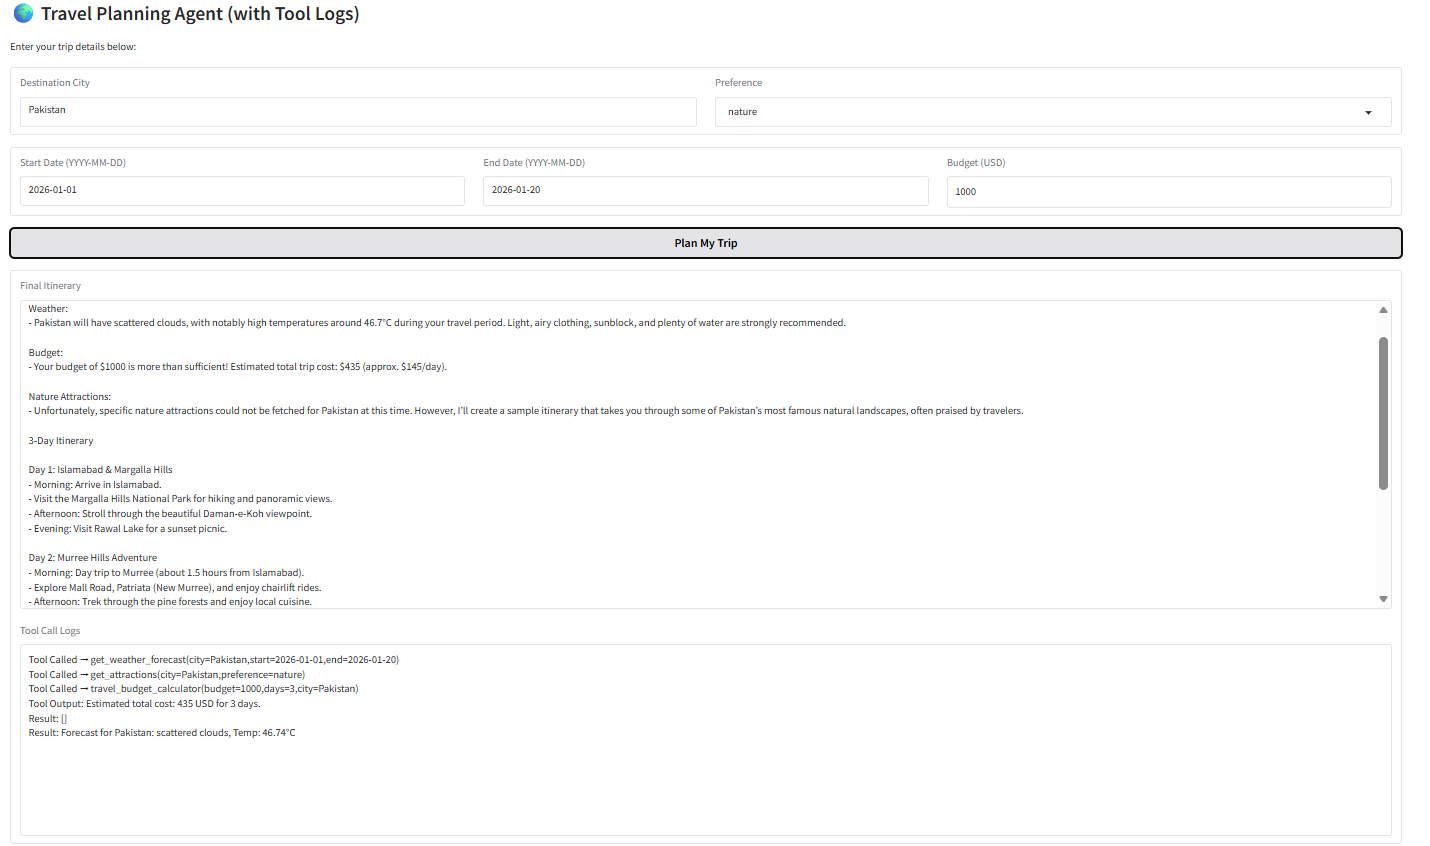